# Mean Flow (MF) - Code Only

## Initialize Distributions

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


**Code:** We will use the standard Gaussian distribution as the source distribution and the “checkerboard distribution” as the target distribution. Let’s set up these two distributions.

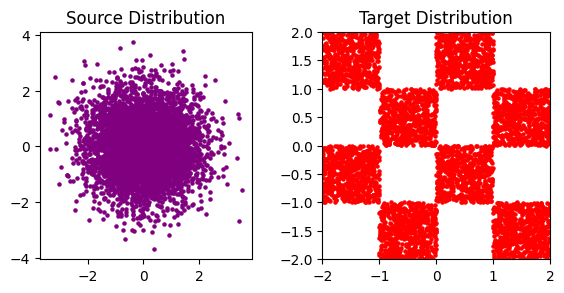

In [ ]:
def sample_checkerboard(N=1000, grid_size=4, scale=2.0):
    """
    Generate samples from a 2D checkerboard distribution.
    This function divides the square domain [-scale, scale] × [-scale, scale]
    into a grid of `grid_size × grid_size` equally sized square cells.
    """
    grid_length = 2 * scale / grid_size
    # Randomly choose integer tile coordinates
    gx = np.random.randint(0, grid_size, size=N)
    gy = np.random.randint(0, grid_size, size=N)
    mask = ((gx % 2) ^ (gy % 2)).astype(bool) # Keep only tiles where (even, odd) or (odd, even) — XOR rule
    while not np.all(mask): # Resample indices until all entries satisfy the checkerboard mask
        bad = np.where(~mask)[0]
        gx[bad] = np.random.randint(0, grid_size, size=len(bad))
        gy[bad] = np.random.randint(0, grid_size, size=len(bad))
        mask = ((gx % 2) ^ (gy % 2)).astype(bool)
    # Sample uniformly inside each chosen tile
    offsets = np.random.rand(N, 2) * grid_length
    xs = -scale + gx * grid_length + offsets[:, 0]
    ys = -scale + gy * grid_length + offsets[:, 1]
    return np.stack([xs, ys], axis=1).astype(np.float32)

def sample_pi_0(N=1000):
  return np.random.randn(N, 2).astype(np.float32)

def sample_pi_1(N=1000, grid_size=4, scale=2.0):
  return sample_checkerboard(N=N, grid_size=grid_size, scale=scale)

# Generate data
pi_0 = sample_pi_0(N=5_000)
grid_size, scale = 4, 2
pi_1 = sample_pi_1(N=5_000, grid_size=grid_size, scale=scale)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(pi_0[:, 0], pi_0[:, 1], c='purple', s=5)
axes[0].set_aspect('equal', 'box')
axes[0].set_title("Source Distribution")
axes[1].scatter(pi_1[:, 0], pi_1[:, 1], c='red', s=5)
axes[1].set_xlim(-scale, scale)
axes[1].set_ylim(-scale, scale)
axes[1].set_aspect('equal', 'box')
axes[1].set_title("Target Distribution")

plt.tight_layout()
plt.show()

## Train Mean Flow

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, context_dim=2, h=128, out_dim=2):
        super(MLP, self).__init__()
        self.context_dim = context_dim
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, t, r=None):
      if r == None:
        return self.network(torch.cat((x, t), dim=1))
      else: # mean flow takes an additional time r
        return self.network(torch.cat((x, t, r), dim=1))


def train_flow(flow_model, n_iterations=5_001, lr=3e-3, batch_size=4096, save_freq=1_000, flow="FM"):
    print(f"Training {flow}")
    optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr)
    losses = []
    checkpoints = []
    progress_bar = tqdm(range(n_iterations), desc="Training Flow Model", ncols=100)
    for iteration in progress_bar:
        x1 = torch.from_numpy(sample_pi_1(N=batch_size)).to(device)
        x0 = torch.from_numpy(sample_pi_0(N=batch_size)).to(device)
        if flow == "FM":
            t = torch.rand((x1.shape[0], 1), device=device) # randomly sample t
            x_t = t * x1 + (1.-t) * x0
            v = x1 - x0
            v_pred = flow_model(x_t, t)
            loss = torch.nn.functional.mse_loss(v_pred, v)
        elif flow == "MF":
            tr = torch.rand((x1.shape[0], 2), device=device)
            t = tr.max(dim=1, keepdim=True).values
            r = tr.min(dim=1, keepdim=True).values
            x_t = t * x1 + (1.-t) * x0
            v = x1 - x0   # conditional velocity given the end points
            dtdt, drdt = torch.ones_like(t), torch.zeros_like(r)
            u_pred, dudt = torch.func.jvp(flow_model, (x_t, t, r), (v, dtdt, drdt))
            u_target = (v - (t - r) * dudt).detach()
            loss = torch.nn.functional.mse_loss(u_pred, u_target)
        else:
            raise NotImplementedError
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})
        if iteration % save_freq == 0:
          checkpoints.append({
              'iteration': iteration,
              'model_state_dict': copy.deepcopy(flow_model.state_dict()),
              'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
              'loss': loss.item(),
          })
    if iteration % save_freq != 0:
      checkpoints.append({
          'iteration': iteration,
          'model_state_dict': copy.deepcopy(flow_model.state_dict()),
          'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
          'loss': loss.item(),
      })
    return flow_model, losses, checkpoints

In [ ]:
MF_model = MLP(in_dim=2, context_dim=2, h=128, out_dim=2).to(device)
trained_model_MF, training_losses_MF,checkpoints_MF = train_flow(flow_model=MF_model, flow="MF")

Training MF


Training Flow Model: 100%|███████████████████████| 5001/5001 [01:01<00:00, 81.85it/s, loss=1.961751]


## Sampling

In [ ]:
def sample_flow(flow_model, N, T, flow="FM"):
    """
    Sample from pi_1 with the flow model in T time steps.
    """
    x = torch.from_numpy(sample_pi_0(N=N)).to(device)
    dt = 1./T
    for i in (range(T)):
        t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        if flow == "FM":
            pred = flow_model(x.squeeze(0), t) # predict v
        elif flow == "MF":
            r = t - dt
            pred = flow_model(x.squeeze(0), t, r) # predict u
        else:
            raise NotImplementedError
        x = x + pred * 1. / T # reverse integration as we learn the velocity from data to noise
    return x

def visualize_flow_sampling(flow_model, N, T, flow="FM"):
    """
    Visualizes the sampling trajectory of the flow model.
    """
    sampled_pi_1 = sample_flow(flow_model, N=N, T=T, flow=flow).detach().cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.scatter(pi_1[:, 0], pi_1[:, 1], s=5, alpha=0.05,
                color='gray', label='Target')
    plt.scatter(sampled_pi_1[:, 0], sampled_pi_1[:, 1], s=5, alpha=0.3,
                color='red', label='Denoised')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_aspect('equal')
    plt.title(f"Denoising Steps = {T}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


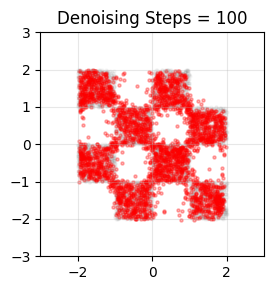

In [ ]:
visualize_flow_sampling(trained_model_MF, N=3000, T=100, flow="MF")

## Flow Matching v.s. Mean Flow: One-step and Multi-step Generation

In [ ]:
FM_model = MLP(in_dim=2, context_dim=1, h=128, out_dim=2).to(device)
trained_model_FM, training_losses_FM,checkpoints_FM = train_flow(flow_model=FM_model, flow="FM")

Training FM


Training Flow Model: 100%|██████████████████████| 5001/5001 [00:38<00:00, 130.16it/s, loss=1.724959]


In [ ]:
def visualize_two_models(FM_model, MF_model, N=2000, steps=[1, 10, 100, 500]):
    """
    Visualize samples from the FM and MF models with various steps.
    """
    fig, axes = plt.subplots(2, len(steps), figsize=(3*len(steps), 6))
    model_list = [(FM_model, "FM"), (MF_model, "MF")]
    for row, (model, flow_name) in enumerate(model_list):
        for col, T in enumerate(steps):
            ax = axes[row, col]
            sampled = sample_flow(model, N=N, T=T, flow=flow_name).detach().cpu().numpy()
            ax.scatter(pi_1[:, 0], pi_1[:, 1], s=5, alpha=0.05, color='gray')
            ax.scatter(sampled[:, 0], sampled[:, 1], s=5, alpha=0.3, color='red')
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            ax.set_aspect('equal')
            ax.set_title(f"{flow_name}, T={T}")
            ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

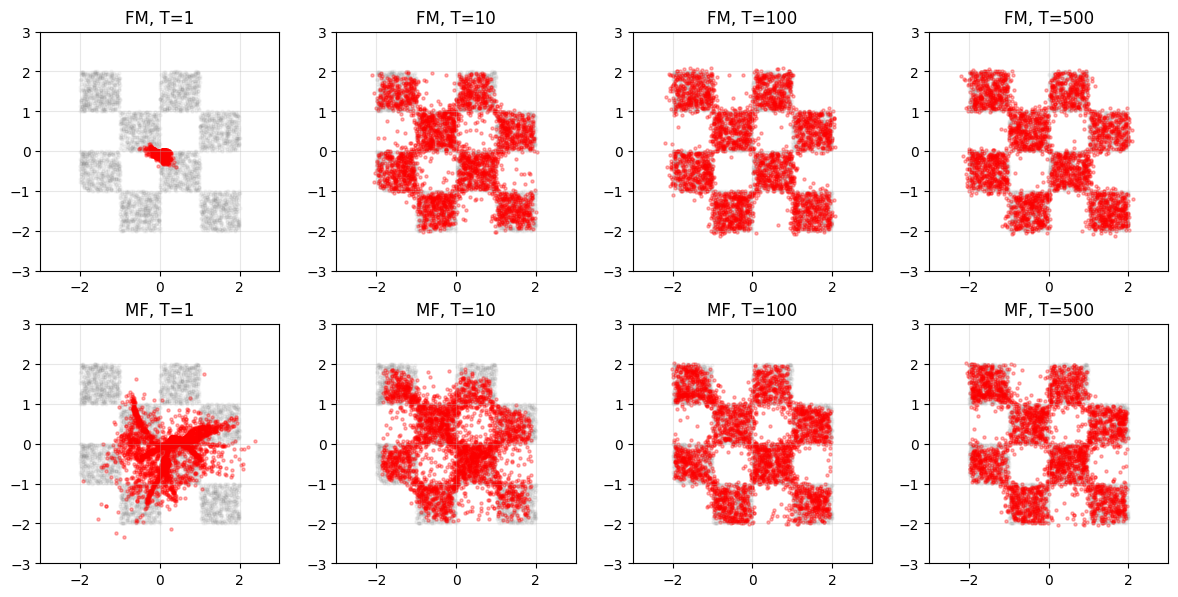

In [ ]:
visualize_two_models(FM_model=trained_model_FM, MF_model=trained_model_MF, N=3000, steps=[1, 10, 100, 500])

## Reverse Training

**Code:** Swap the two distributions.

In [ ]:
def sample_pi_1(N=1000):
  return np.random.randn(N, 2).astype(np.float32)

def sample_pi_0(N=1000, grid_size=4, scale=2.0):
  return sample_checkerboard(N=N, grid_size=grid_size, scale=scale)
# Generate data
grid_size, scale = 4, 2
pi_0 = sample_pi_0(N=5_000, grid_size=grid_size, scale=scale)

In [ ]:
FM_model_reverse = MLP(in_dim=2, context_dim=1, h=128, out_dim=2).to(device)
trained_model_FM_reverse, training_losses_FM_reverse, checkpoints_FM_reverse = train_flow(flow_model=FM_model_reverse, flow="FM")
MF_model_reverse = MLP(in_dim=2, context_dim=2, h=128, out_dim=2).to(device)
trained_model_MF_reverse, training_losses_MF_reverse, checkpoints_MF_reverse = train_flow(flow_model=MF_model_reverse, flow="MF")

Training FM


Training Flow Model: 100%|██████████████████████| 5001/5001 [00:35<00:00, 142.46it/s, loss=1.730881]


Training MF


Training Flow Model: 100%|███████████████████████| 5001/5001 [01:00<00:00, 82.94it/s, loss=3.173201]


## Reverse Integration: One-step and Multi-step

In [ ]:
def sample_flow(flow_model, N, T, flow="FM", reverse=True):
    """
    Sample from pi_0 (checkboard) with the flow model in T time steps.
    """
    x = torch.from_numpy(sample_pi_1(N=N)).to(device)
    dt = 1./T
    for i in (range(T)):
        if reverse: # time starts from 1
          t = torch.ones((x.shape[0], 1), device=x.device) * (1 - i * dt)
        else: # time starts from 0
          t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        if flow == "FM":
            pred = flow_model(x.squeeze(0), t) # predict v
        elif flow == "MF":
            r = t - dt
            pred = flow_model(x.squeeze(0), t, r) # predict u
        else:
            raise NotImplementedError
        x = x - pred * 1. / T if reverse else x + pred * 1. / T
    return x

In [ ]:
def visualize_two_models(FM_model, MF_model, N=2000, steps=[1, 10, 100, 500], reverse=True):
    """
    Visualize samples from the FM and MF models with various steps.
    """
    fig, axes = plt.subplots(2, len(steps), figsize=(3*len(steps), 6))
    model_list = [(FM_model, "FM"), (MF_model, "MF")]
    for row, (model, flow_name) in enumerate(model_list):
        for col, T in enumerate(steps):
            ax = axes[row, col]
            sampled = sample_flow(model, N=N, T=T, flow=flow_name, reverse=reverse).detach().cpu().numpy()
            ax.scatter(pi_0[:, 0], pi_0[:, 1], s=5, alpha=0.05, color='gray')
            ax.scatter(sampled[:, 0], sampled[:, 1], s=5, alpha=0.3, color='red')
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            ax.set_aspect('equal')
            ax.set_title(f"Reverse {flow_name}, T={T}")
            ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

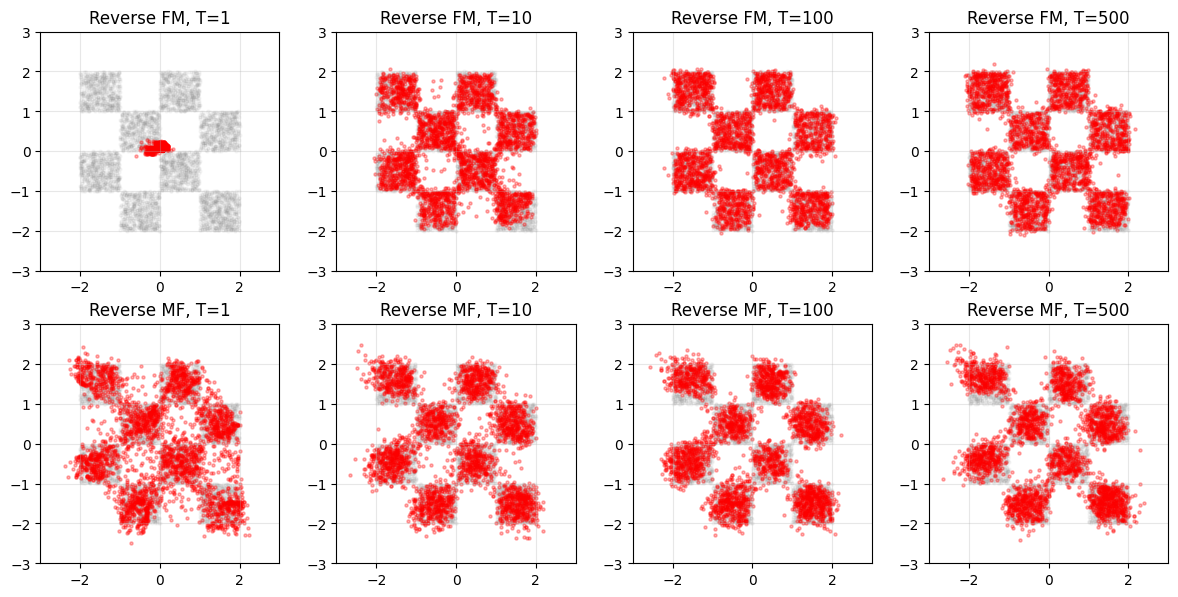

In [ ]:
visualize_two_models(FM_model=trained_model_FM_reverse, MF_model=trained_model_MF_reverse, N=3000, steps=[1, 10, 100, 500], reverse=True)

## Additional Visualization

### Evolution: $\pi_0$ to $\pi_1$

In [ ]:
def sample_flow_xt(flow_model, N, T, num_xt, flow="FM", reverse=True):
    """
    Generate N samples from pi_1 with the flow model in T timesteps.
    Also save the sample X_t for intermidiate time between 0 and 1.
    """
    record_times = torch.linspace(0.0, 1.0, steps=num_xt).tolist()
    record_times = sorted(record_times)
    dt = 1.0 / T
    target_indices = {
        rt: int(round(rt / dt)) if not reverse else int(round((1 - rt) / dt))
        for rt in record_times
    }
    xt = {}
    x = torch.from_numpy(sample_pi_1(N=N)).to(device)
    # record starting state if needed
    if 0 in target_indices and not reverse:
        xt[0] = x.clone()
    if 1 in target_indices and reverse:
        xt[1] = x.clone()
    for i in range(T):
        if reverse:
            t = torch.ones((x.shape[0], 1), device=x.device) * (1 - i * dt)
        else:
            t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        if flow == "FM":
            pred = flow_model(x, t)
        elif flow == "MF":
            r = t - dt
            pred = flow_model(x, t, r)
        else:
            raise NotImplementedError
        x = x - pred * dt if reverse else x + pred * dt
        for rt, idx in target_indices.items():
            if idx == i + 1:
                xt[rt] = x.clone()

    return xt

In [ ]:
def visualize_two_mean_flows_xt(FM_model, MF_model, N, T, num_xt, max_cols=8, reverse=True):
    """
    Visualize intermediate X_t samples for two flow models.
    """
    xt_FM = sample_flow_xt(FM_model, N=N, T=T, num_xt=num_xt, flow="FM", reverse=reverse)
    xt_MF = sample_flow_xt(MF_model, N=N, T=T, num_xt=num_xt, flow="MF", reverse=reverse)
    times_sorted = list(xt_FM.keys())
    K = len(times_sorted)
    cols = min(max_cols, K)
    rows_per_model = int(np.ceil(K / cols))
    total_rows = 2 * rows_per_model

    fig, axes = plt.subplots(total_rows, cols, figsize=(2*cols, 2*total_rows))
    axes = axes.reshape(total_rows, cols)

    target = pi_0
    def fill_row_block(ax_block, xt_dict, model_name):
        idx = 0
        for i in range(ax_block.shape[0]):
            for j in range(ax_block.shape[1]):
                ax = ax_block[i, j]
                if idx < K:
                    t = times_sorted[idx]
                    xt = xt_dict[t].detach().cpu().numpy()
                    ax.scatter(target[:, 0], target[:, 1], s=1, alpha=0.05, color='gray')
                    ax.scatter(xt[:, 0], xt[:, 1], s=3, alpha=0.4, color='red')
                    ax.set_xlim(-3, 3)
                    ax.set_ylim(-3, 3)
                    ax.set_aspect('equal')
                    ax.grid(True, alpha=0.3)
                    ax.set_title(f"{model_name} | t={t:.2f}")
                else:
                    ax.axis("off")
                idx += 1
    fill_row_block(axes[:rows_per_model], xt_FM, "FM")
    fill_row_block(axes[rows_per_model:], xt_MF, "MF")

    plt.tight_layout()
    plt.show()


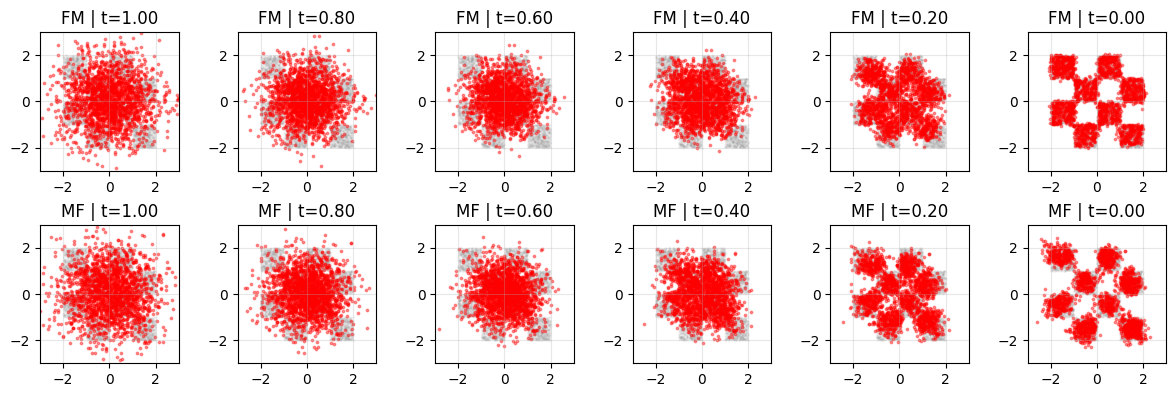

In [ ]:
visualize_two_flows_xt(FM_model=trained_model_FM_reverse, MF_model=trained_model_MF_reverse,
                            N=2000,
                            T=100,
                            num_xt=6,
                            max_cols=8,
                            reverse=True)

### Samping at Different Training Stages

In [ ]:
def visualize_all_checkpoints_two_models(
    flow_model_FM, checkpoints_FM,
    flow_model_MF, checkpoints_MF,
    N, T, max_cols=4, reverse=True):
    """
    Plot sampling for two models (FM and MF). Each model occupies one row. Columns correspond to checkpoints.
    """
    num_plots = max(len(checkpoints_FM), len(checkpoints_MF))
    cols = min(max_cols, num_plots)
    rows = 2  # FM row + MF row
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))

    # Ensure axes is always 2D
    if rows == 1:
        axes = axes[np.newaxis, :]

    # ----------------------------------------
    # Helper to plot one entire row of a model
    # ----------------------------------------
    def plot_model_row(ax_row, model, checkpoints, flow, reverse):
        for col in range(cols):
            ax = ax_row[col]

            if col < len(checkpoints):
                checkpoint = checkpoints[col]
                iteration = checkpoint["iteration"]
                # Load model parameters
                model.load_state_dict(checkpoint["model_state_dict"])
                # Sample from the model
                sampled = sample_flow(model, N=N, T=T, flow=flow, reverse=reverse).detach().cpu().numpy()
                # Plot target distribution (gray)
                ax.scatter(pi_1[:, 0], pi_1[:, 1], s=1, alpha=0.05, color="gray")
                # Plot samples (red)
                ax.scatter(sampled[:, 0], sampled[:, 1], s=3, alpha=0.3, color="red")
                ax.set_xlim(-3, 3)
                ax.set_ylim(-3, 3)
                ax.set_aspect("equal")
                ax.set_title(f"{flow} — ite={iteration}")
                ax.grid(True, alpha=0.3)
            else:
                ax.axis("off")
    # FM in first row
    plot_model_row(axes[0], flow_model_FM, checkpoints_FM, "FM", reverse)
    # MF in second row
    plot_model_row(axes[1], flow_model_MF, checkpoints_MF, "MF", reverse)
    plt.tight_layout()
    plt.show()



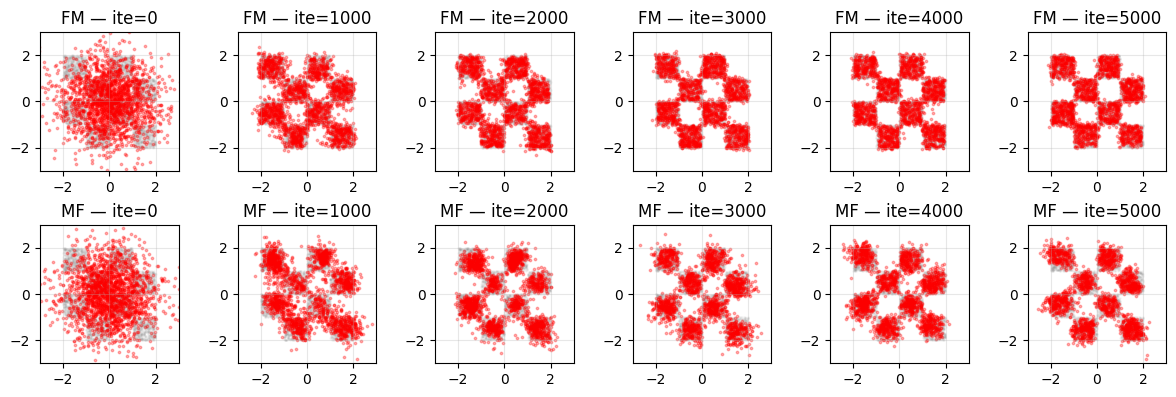

In [ ]:
visualize_all_checkpoints_two_models(
    flow_model_FM=trained_model_FM, checkpoints_FM=checkpoints_FM_reverse,
    flow_model_MF=trained_model_MF, checkpoints_MF=checkpoints_MF_reverse,
    N=2000, T=100, max_cols=6, reverse=True)